In [2]:
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
# import i2v
import numpy as np
import matplotlib.pyplot as plt

## 构造数据集

In [2]:
categories = ['disgust','fear','happy','surprise','sad','angry','neutral']
# label = 0,1,2,3,4,5,6

In [3]:
file_train = []
file_test = []
number_train = []
number_test = []

In [4]:
# categories.index('neutral')
# number_train.append(1)
# number_train

In [5]:
# category = 'neutral'
for category in categories:
    label = categories.index(category)
    for root,dirs,files in os.walk("..//detect_faces//"+str(category)): 
        for file in files:
            file_type = file.split('_')[1]
    #         print(file_type)
            # train_data
            if file_type == 'train':
                file_train.append(os.path.join(root,file))
                number_train.append(label)
            else:
                file_test.append(os.path.join(root,file))
                number_test.append(label)

In [6]:
print("trainset_size: "+ str(len(file_train)))
print("testset_size: "+ str(len(file_test)))

trainset_size: 32080
testset_size: 8016


In [7]:
class testset(Dataset):
    def __init__(self, transform=None):
        #定义好 image 的路径
        self.images = file_test
        self.target = number_test
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(image)
        if self.transform:
            image = self.transform(image)
        target = self.target[index]
        return image,target

    def __len__(self):
        return len(self.images)

In [8]:
class trainset(Dataset):
    def __init__(self, transform=None):
        #定义好 image 的路径
        self.images = file_train
        self.target = number_train
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(image)
        if self.transform:
            image = self.transform(image)
        target = self.target[index]
        return image,target

    def __len__(self):
        return len(self.images)

In [9]:
# 应用了torchvision.transforms.ToTensor，其作用是将数据归一化到[0,1]（是将数据除以255）
# [0.485, 0.456, 0.406]这一组平均值是从imagenet训练集中抽样算出来的。
# 数据如果分布在(0,1)之间，可能实际的bias，就是神经网络的输入b会比较大，
# 而模型初始化时b=0的，这样会导致神经网络收敛比较慢，经过Normalize后，可以加快模型的收敛速度。
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [10]:
train_dataset = trainset(transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)
test_dataset = testset(transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64,shuffle=False)

## 模型搭建

In [11]:
class Net1(torch.nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.conv3 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.pooling1 = torch.nn.MaxPool2d(2)
        self.pooling2 = torch.nn.MaxPool2d(4)
        self.fc1 = torch.nn.Linear(4096,4096)
        self.fc2 = torch.nn.Linear(4096,4096)
        self.fc3 = torch.nn.Linear(4096,7)
    
    def forward(self,x):
        batch_size = x.size(0)
        x = self.pooling1(F.relu(self.conv1(x)))
        x = self.pooling2(F.relu(self.conv2(x)))
        x = self.pooling2(F.relu(self.conv3(x)))
        # flatten
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# class Net2(torch.nn.Module):
#     def __init__(self):
#         super(Net2,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.conv4 = torch.nn.Conv2d(256,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
#         self.fc3 = torch.nn.Linear(4096,7)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = self.pooling2(F.relu(self.conv2(x)))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.pooling2(x)
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [ ]:
# class Net3(torch.nn.Module):
#     def __init__(self):
#         super(Net3,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,128,kernel_size=3,padding=1)
#         self.conv4 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.conv5 = torch.nn.Conv2d(256,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
#         self.fc3 = torch.nn.Linear(4096,7)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = self.pooling2(x)
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
#         x = self.pooling2(x)
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [ ]:
# # Ensemble模型
# class Net1_mix(torch.nn.Module):
#     def __init__(self):
#         super(Net1,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = self.pooling2(F.relu(self.conv2(x)))
#         x = self.pooling2(F.relu(self.conv3(x)))
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return x
# class Net2_mix(torch.nn.Module):
#     def __init__(self):
#         super(Net2,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.conv4 = torch.nn.Conv2d(256,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = self.pooling2(F.relu(self.conv2(x)))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.pooling2(x)
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return x
# class Net3_mix(torch.nn.Module):
#     def __init__(self):
#         super(Net3,self).__init__()
#         self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,padding=1)
#         self.conv2 = torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
#         self.conv3 = torch.nn.Conv2d(128,128,kernel_size=3,padding=1)
#         self.conv4 = torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
#         self.conv5 = torch.nn.Conv2d(256,256,kernel_size=3,padding=1)
#         self.pooling1 = torch.nn.MaxPool2d(2)
#         self.pooling2 = torch.nn.MaxPool2d(4)
#         self.fc1 = torch.nn.Linear(4096,4096)
#         self.fc2 = torch.nn.Linear(4096,4096)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x = self.pooling1(F.relu(self.conv1(x)))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = self.pooling2(x)
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
#         x = self.pooling2(x)
#         # flatten
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return x
# # 声明网络
# model_net1 = Net1_mix()
# model_net2 = Net2_mix()
# model_net3 = Net3_mix()
# # 导入参数
# save_path = '..//Final-Project//model_save//'
# state_dict1 = torch.load(save_path+"Net1_epoch60.pth")
# state_dict2 = torch.load(save_path+"Net2_epoch60.pth")
# state_dict3 = torch.load(save_path+"Net3_epoch60.pth")

# keys = []
# for k,v in state_dict1.items():
#   #将‘fc3’开头的key过滤掉，这里是要去除的层的key
#     if k.startswith('fc3'):  
#         continue
#     keys.append(k)

# # 去除指定层后的模型
# state_dict1 = {k:state_dict1[k] for k in keys}

# keys = []
# for k,v in state_dict2.items():
#   #将‘fc3’开头的key过滤掉，这里是要去除的层的key
#     if k.startswith('fc3'):  
#         continue
#     keys.append(k)
# # 去除指定层后的模型
# state_dict2 = {k:state_dict1[k] for k in keys}

# keys = []
# for k,v in state_dict2.items():
#   #将‘fc3’开头的key过滤掉，这里是要去除的层的key
#     if k.startswith('fc3'):  
#         continue
#     keys.append(k)

# # 去除指定层后的模型
# state_dict3 = {k:state_dict1[k] for k in keys}

# #自己定义的模型，但要保证前面保存的层和自定义的模型中的层一致
# model_net1.load_state_dict(state_dict1)
# model_net2.load_state_dict(state_dict2)
# model_net3.load_state_dict(state_dict3)

# class NetMix(torch.nn.Module):
#     def __init__(self):
#         super(NetMix,self).__init__()
#         self.net1 = model_net1
#         self.net2 = model_net2
#         self.net3 = model_net3
#         for p in self.parameters():
#             p.requires_grad = False #预训练模型加载进来后全部设置为不更新参数，然后再后面加层
#         self.fc = torch.nn.Linear(4096*3,7)
    
#     def forward(self,x):
#         batch_size = x.size(0)
#         x1 = net1(x)
#         x2 = net2(x)
#         x3 = net3(x)
#         # 拼接输入
#         x = torch.cat((x1,x2,x3),dim = 1)
#         # 输出
#         x = self.fc(x)
#         return x

## 模型配置

### Net1配置

In [12]:
model = Net1()

### Net2配置

In [13]:
# model = Net2()

### Net3配置

In [14]:
# model = Net3()

### Net1+2+3配置

In [15]:
# model = NetMix()

### 共同配置

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
device

device(type='cuda', index=0)

In [18]:
model.to(device)

Net1(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pooling2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=7, bias=True)
)

In [19]:
# 损失、优化函数定义
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)

# 带冲量的优化，冲量为0.5
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [20]:
# result = []
# one_hot = [0,0,0,0,0,0,0]
# one_hot[1] = 1
# result.append(one_hot)
# result.append(one_hot)
# torch.Tensor(result)

In [21]:
def get_one_hot(labels):
    result = []
    # batch_size=64
    size = len(labels)
    for i in range(size):
        one_hot = [0,0,0,0,0,0,0]
        one_hot[labels[i]] = 1
        result.append(one_hot)
    return torch.Tensor(result)

In [22]:
def train(epoch):
    running_loss = 0.0
    total = 0
    correct = 0
    for batch_idx,data in enumerate(train_loader,0):
        inputs, target = data
        # 转换为one-hot向量
        target_one_hot = get_one_hot(target)
        # 将用来计算的张量迁移到GPU
        inputs, target_one_hot = inputs.to(device), target_one_hot.to(device)
        
        # 初始化优化器
        optimizer.zero_grad()
        
        # forward+backward+update
        outputs = model(inputs)
        
        with torch.no_grad():
            target = target.to(device)
            # 沿着第一个维度取最大值的下标，返回最大值、最大值下标
            _, predicted = torch.max(outputs.data, dim=1)
            total += target.size(0)
            # 计算训练集准确率
            correct += (predicted == target).sum().item()
        
        loss = criterion(outputs, target_one_hot)
        # 将用来计算的张量迁移到GPU
        loss = loss.to(device)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if batch_idx % 500 == 499:
            # 以500个patch的平均loss作为此epoch的loss
            train_loss_list.append(running_loss / 500)
            print('[%d, %5d] loss: %.3f' % (epoch + 1,batch_idx + 1, running_loss / 500))
            running_loss = 0.0
            # 以500个patch的平均accuracy作为此epoch的accuracy
            train_accuracy_list.append(100 * correct/total)
            print('Accuracy on train set: %d %% [%d/%d]' % (100 * correct/total,correct,total))
            correct = 0
            total = 0

In [23]:
def test():
    correct = 0
    total = 0
    error = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data

            # 将用来计算的张量迁移到GPU
            images, labels = images.to(device), labels.to(device)
            # 用于计算测试集损失
            one_hot_labels = get_one_hot(labels)
            one_hot_labels = one_hot_labels.to(device)
            
            outputs = model(images)
            
            # 计算测试集损失
            error += F.cross_entropy(outputs,one_hot_labels).sum().item()
            
            # 沿着第一个维度取最大值的下标，返回最大值、最大值下标
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            # 计算测试集准确率
            correct += (predicted == labels).sum().item()
            
        test_accuracy_list.append(100 * correct/total)
        test_loss_list.append(error / total)
        print('Accuracy on test set: %d %% [%d/%d]' % (100 * correct/total,correct,total))

## 训练

In [24]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

In [7]:
# 作图（100epochs）
def plot_loss():
    # 1.创建画布
#     plt.figure(figsize=(10,8),dpi=100)
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8),dpi=100)

    # 2.绘制图像
    epochs = np.linspace(1,100,100)
#     train_loss = epochs
#     test_loss = epochs + 10
#     train_accuracy = epochs + 10
#     test_accuracy = epochs
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss(CE)/patch")
    axes[0].set_title("loss", fontsize=10)
    axes[0].plot(epochs, train_loss_list, color = 'r',label="train_loss")
    axes[0].plot(epochs, test_loss_list, color = 'b',label="test_loss")
    axes[0].legend(loc="best")
    
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy(%)")
    axes[1].set_title("accuracy", fontsize=10)
    axes[1].plot(epochs, train_accuracy_list, color = 'r',label="train_accuracy")
    axes[1].plot(epochs, test_accuracy_list, color = 'b',label="test_accuracy")
    axes[1].legend(loc="best")
    
    plt.show()     #显示图片

In [26]:
if __name__ == '__main__':
    save_path = '..//Final-Project//model_save//'
    for epoch in range(100):
        epoch = epoch
        train(epoch)
        test()
        # 5个epoch保存一次模型
        if epoch % 5 == 4:
            torch.save(model.state_dict(), save_path+"Net1_epoch"+ str(epoch+1)+ '.pth')

[1,   500] loss: 1.553
Accuracy on train set: 36 % [11771/32000]
Accuracy on test set: 46 % [3747/8016]
[2,   500] loss: 1.233
Accuracy on train set: 49 % [15997/32000]
Accuracy on test set: 45 % [3637/8016]
[3,   500] loss: 1.127
Accuracy on train set: 54 % [17408/32000]
Accuracy on test set: 52 % [4243/8016]
[4,   500] loss: 1.055
Accuracy on train set: 57 % [18357/32000]
Accuracy on test set: 44 % [3551/8016]
[5,   500] loss: 0.999
Accuracy on train set: 59 % [19103/32000]
Accuracy on test set: 55 % [4452/8016]
[6,   500] loss: 0.948
Accuracy on train set: 61 % [19834/32000]
Accuracy on test set: 51 % [4142/8016]
[7,   500] loss: 0.899
Accuracy on train set: 64 % [20492/32000]
Accuracy on test set: 56 % [4542/8016]
[8,   500] loss: 0.853
Accuracy on train set: 66 % [21184/32000]
Accuracy on test set: 38 % [3101/8016]
[9,   500] loss: 0.806
Accuracy on train set: 67 % [21696/32000]
Accuracy on test set: 57 % [4611/8016]
[10,   500] loss: 0.750
Accuracy on train set: 70 % [22425/32000

Accuracy on test set: 63 % [5057/8016]
[80,   500] loss: 0.021
Accuracy on train set: 98 % [31557/32000]
Accuracy on test set: 63 % [5077/8016]
[81,   500] loss: 0.021
Accuracy on train set: 98 % [31556/32000]
Accuracy on test set: 62 % [5006/8016]
[82,   500] loss: 0.020
Accuracy on train set: 98 % [31556/32000]
Accuracy on test set: 62 % [5000/8016]
[83,   500] loss: 0.020
Accuracy on train set: 98 % [31560/32000]
Accuracy on test set: 62 % [4998/8016]
[84,   500] loss: 0.021
Accuracy on train set: 98 % [31535/32000]
Accuracy on test set: 62 % [5041/8016]
[85,   500] loss: 0.020
Accuracy on train set: 98 % [31556/32000]
Accuracy on test set: 62 % [4989/8016]
[86,   500] loss: 0.020
Accuracy on train set: 98 % [31548/32000]
Accuracy on test set: 62 % [4981/8016]
[87,   500] loss: 0.020
Accuracy on train set: 98 % [31585/32000]
Accuracy on test set: 62 % [5046/8016]
[88,   500] loss: 0.020
Accuracy on train set: 98 % [31569/32000]
Accuracy on test set: 62 % [5011/8016]
[89,   500] loss

In [27]:
# 换算为每个patch的loss
test_loss_list_patch = [i * 64 for i in test_loss_list]
test_loss_list = test_loss_list_patch

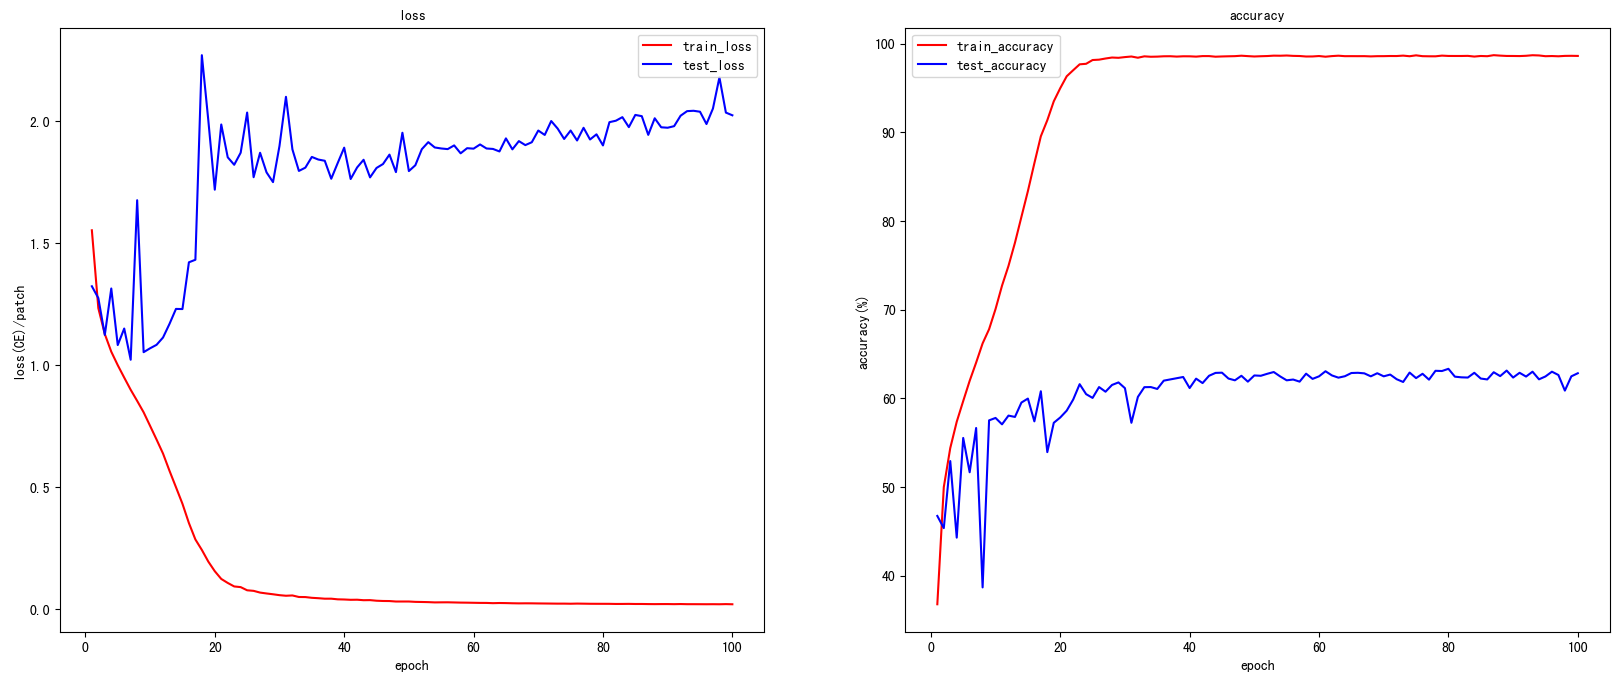

In [28]:
plot_loss()

## 保存与加载

In [29]:
# 保存loss与accuracy
# train_loss_list = np.array(train_loss_list)
# test_loss_list = np.array(test_loss_list)
# train_accuracy_list = np.array(train_accuracy_list)
# test_accuracy_list = np.array(test_accuracy_list)
# np.savetxt("..//Final-Project//log_save//Net1_train_loss_list.txt",train_loss_list)
# np.savetxt("..//Final-Project//log_save//Net1_test_loss_list.txt",test_loss_list)
# np.savetxt("..//Final-Project//log_save//Net1_train_accuracy_list.txt",train_accuracy_list)
# np.savetxt("..//Final-Project//log_save//Net1_test_accuracy_list.txt",test_accuracy_list)

In [30]:
# state_dict = torch.load(save_path+"Net1_epoch60.pth")
# model.load_state_dict(state_dict)

In [34]:
train_loss_list = np.loadtxt("..//Final-Project//log_save//Net1_train_loss_list.txt")
test_loss_list = np.loadtxt("..//Final-Project//log_save//Net1_test_loss_list.txt")
train_accuracy_list = np.loadtxt("..//Final-Project//log_save//Net1_train_accuracy_list.txt")
test_accuracy_list = np.loadtxt("..//Final-Project//log_save//Net1_test_accuracy_list.txt")

In [35]:
test_accuracy_list.max()

63.33582834331337

In [24]:
train_loss_list = train_loss_list[0:40]
test_loss_list = test_loss_list[0:40]
train_accuracy_list = train_accuracy_list[0:40]
test_accuracy_list = test_accuracy_list[0:40]

In [15]:
# 作图（40epochs）
def plot_loss_40():
    # 1.创建画布
#     plt.figure(figsize=(10,8),dpi=100)
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8),dpi=100)

    # 2.绘制图像
    epochs = np.linspace(1,40,40)
#     train_loss = epochs
#     test_loss = epochs + 10
#     train_accuracy = epochs + 10
#     test_accuracy = epochs
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss(CE)/patch")
    axes[0].set_title("loss", fontsize=10)
    axes[0].plot(epochs, train_loss_list, color = 'r',label="train_loss")
    axes[0].plot(epochs, test_loss_list, color = 'b',label="test_loss")
    axes[0].legend(loc="best")
    
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy(%)")
    axes[1].set_title("accuracy", fontsize=10)
    axes[1].plot(epochs, train_accuracy_list, color = 'r',label="train_accuracy")
    axes[1].plot(epochs, test_accuracy_list, color = 'b',label="test_accuracy")
    axes[1].legend(loc="best")
    
    plt.show()     #显示图片

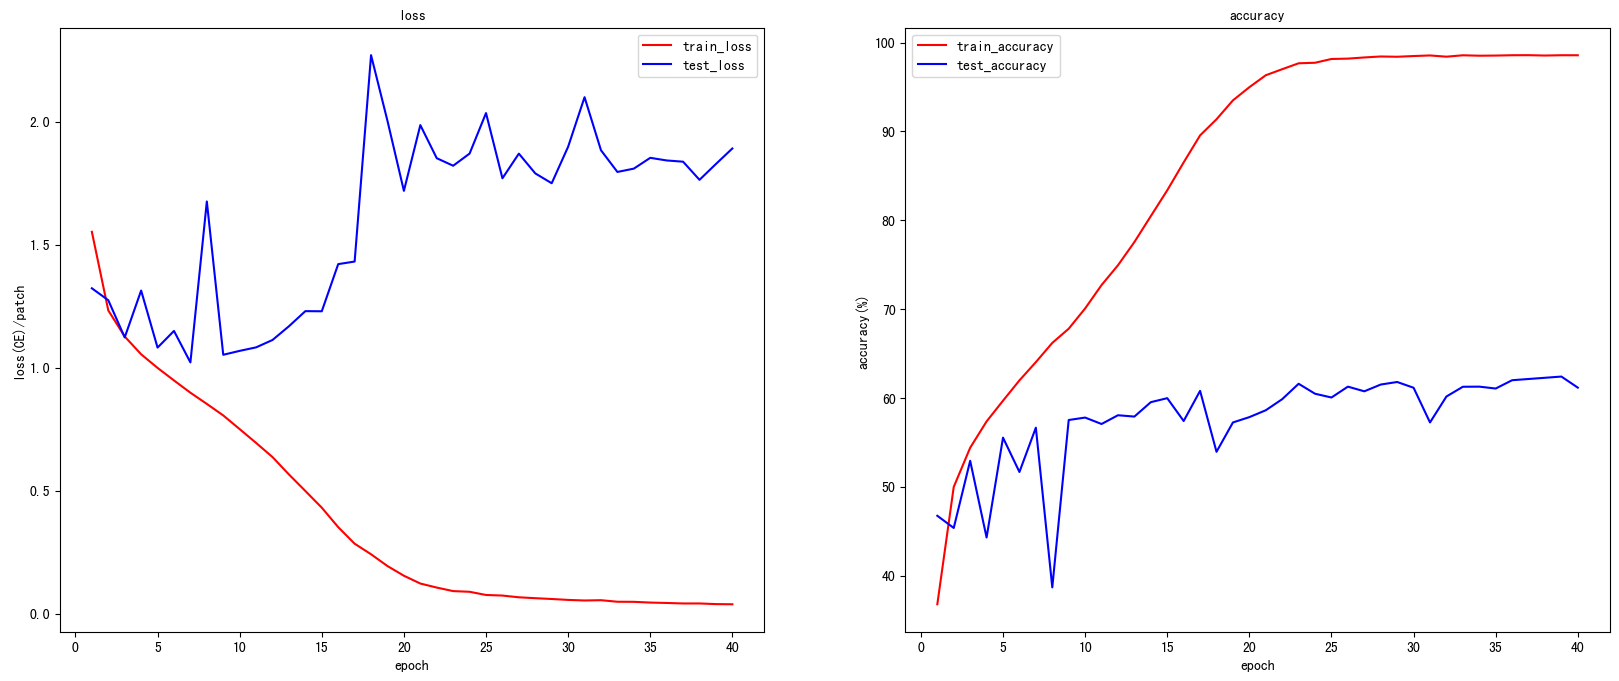

In [16]:
plot_loss_40()

In [25]:
test_accuracy_list.argmax()

38

In [26]:
test_accuracy_list.max()

62.412674650698605

In [22]:
test_loss_list.min()

1.0216909252895328

In [33]:
print(test_loss_list[10])
print(test_accuracy_list[10])

1.0828354310192272
57.07335329341317
